In [1]:
from src import incremental_transformer as it
from src import predictor as pred
import pandas as pd
from src import normalization as norm
import numpy as np
%matplotlib inline

In [2]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

In [3]:
def mape(prediction, target):
    return np.mean(np.abs((target - prediction) / target)) * 100

In [4]:
def smape(prediction, target):
    return np.mean(np.abs(target - prediction) / np.abs(target + prediction)) * 200

In [5]:
def mae(prediction, target):
    return np.mean(np.abs(target - prediction)) * 100

In [6]:
def mdae(prediction, target):
    return np.median(np.abs(target - prediction)) * 100

In [7]:
filename = "D:/energo_data/01_zilina_suma.csv"
data = pd.DataFrame.from_csv(filename, index_col=[0,1])

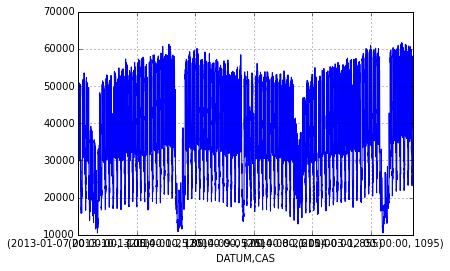

In [3]:
data.SUM_of_MNOZSTVO.plot()

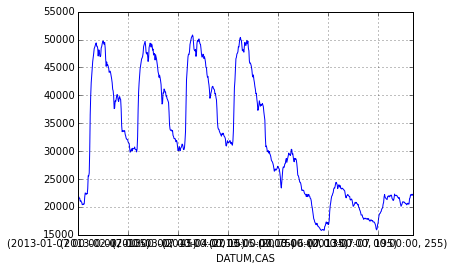

In [4]:
data.SUM_of_MNOZSTVO[:(96*7)].plot()

In [8]:
normalization = norm.ZNormalization()

In [9]:
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(data.SUM_of_MNOZSTVO[0:(96*7)])

In [10]:
trans = it.IncrementalTransformer(96, 48, 2.0, normalization=normalization)
symbols = trans.transform(data.SUM_of_MNOZSTVO[0:(96*7)])

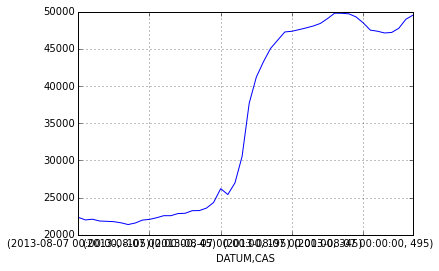

In [11]:
data.SUM_of_MNOZSTVO[(96*7):(96*7+48)].plot()

In [12]:
predictor = pred.Predictor(trans)
prediction = predictor.predict()

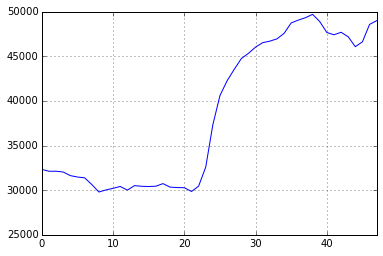

In [13]:
p = (prediction[48:] * normalization.scale) + normalization.shift
pd.Series(p).plot()

In [50]:
t = data.SUM_of_MNOZSTVO[(96*7):(96*7+48)]

In [52]:
rmse(p, t)

5657.6501701570023

In [57]:
smape(p, t)

15.105896701552288

In [29]:
test_data = data.SUM_of_MNOZSTVO[:(96*7*2)]

In [30]:
week = 96*7
symbol_length = 96
step = 48

normalization = norm.ZNormalization()
normalization.train_coefficients(test_data[0:week])
trans = it.IncrementalTransformer(symbol_length, step, 0.5, normalization=normalization)
symbols = trans.transform(test_data[0:(week-step)])
predictor = pred.Predictor(trans)

rmse_result = []
smape_result = []

t_target = pd.Series([])
t_prediction = pd.Series([])

i = week
length = len(test_data)
while(i <= length - step):
    symbols = trans.transform(test_data[(i-step):i])        
    prediction = predictor.predict()
    t = test_data[i:(i+step)]
    t_target = t_target.append(t)
    p = (prediction[step:] * normalization.scale) + normalization.shift
    t_prediction = t_prediction.append(pd.Series(p))
    rmse_result.append(rmse(p, t))
    smape_result.append(smape(p, t))
    if(i % week == 0): # vzyd po tyzdni sa updatuju koeficienty normalizacie aby sa odstranili sezonne vplyvy vacsie ako 1 tyzden
        normalization.train_coefficients(test_data[(i-week):i])
    i+=step


In [31]:
t_prediction = t_prediction.reset_index()
t_target = t_target.reset_index()

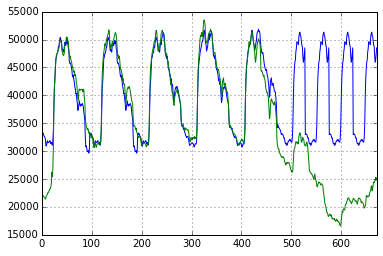

In [32]:
t_prediction[0].plot()
t_target['SUM_of_MNOZSTVO'].plot()

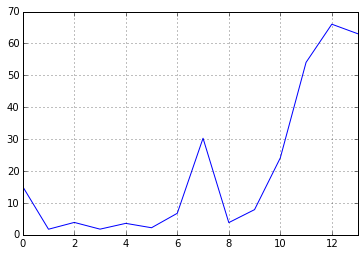

In [66]:
pd.Series(smape_result).plot()

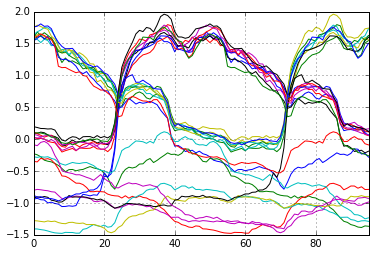

In [72]:
[ pd.Series(symbol.series).plot() for symbol in trans.distance_matrix.symbols()]

#todo
teraz to treba vlozit do nejakeho cyklu, ktory bude postupne davat data po poldnoch a bude predikovat presnost na dalsom poldni. Presnost sa bude vyhodnocovat inkrementalne tak aby som sa mohol pozriet na to, ci sa nejak zlepsuje. Ak to bude prilis rozlietane, tak mozem robit nejake vyhladzovanie (priemer cez running window).
Treba si ale pamatat, ze po kazdom tyzdni musim preucit normalziacne koeficienty aby som odstranil problemy so sezonnostou na vyssej urovni ako je jeden tyzden
najvacsi vyznam ma pouzivat metriky rmse, smape a mae. Z tychto len smape je percentualna, takze nezavysla na pouzitych datach

In [51]:
test_data = data.SUM_of_MNOZSTVO[:(96*14)]

week = 96*7
symbol_length = 96
step = 48

normalization = norm.ZNormalization()
normalization.train_coefficients(test_data[0:week])
trans = it.IncrementalTransformer(symbol_length, step, 0.5, normalization=normalization)
symbols = trans.transform(test_data[0:(week-step)])
predictor = pred.Predictor(trans)

rmse_result = []
smape_result = []

t_target = pd.Series([])
t_prediction = pd.Series([])
last_target = None
last_prediction = None

i = week
length = len(test_data)
while(i <= length - (step * 2)):
    symbols = trans.transform(test_data[(i-step):i])        
    prediction = predictor.predict()
    t = test_data[i:(i+step)]
    last_target = test_data[(i-step):(i+step)]
    t_target = t_target.append(t)
    p = (prediction[step:] * normalization.scale) + normalization.shift
    last_prediction = prediction
    t_prediction = t_prediction.append(pd.Series(p))
    rmse_result.append(rmse(p, t))
    smape_result.append(smape(p, t))
    if(i % week == 0):
        normalization.train_coefficients(test_data[(i-week):i])
    i+=step

t_prediction = t_prediction.reset_index()
t_target = t_target.reset_index()

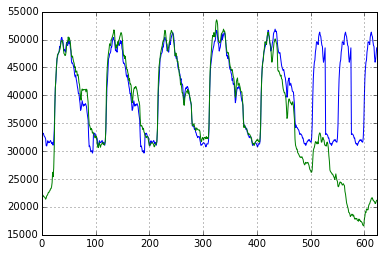

In [52]:
t_prediction[0].plot()
t_target['SUM_of_MNOZSTVO'].plot()

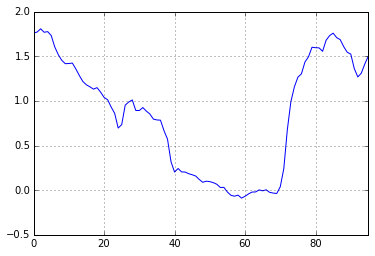

In [48]:
pd.Series(last_prediction).plot()

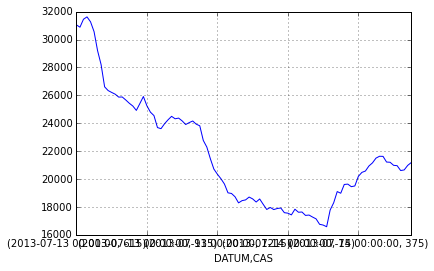

In [49]:
pd.Series(last_target).plot()

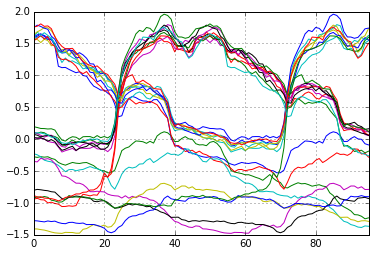

In [53]:
[ pd.Series(symbol.series).plot() for symbol in trans.distance_matrix.symbols()]